In [17]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments
from datasets import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

In [25]:
df = pd.read_csv('data_encoded.csv')
df_train = df
len(df)

1811

# dataset statistical analysis

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Sample data: each tuple represents a set of labels
data = [
    ('A', 'B'),
    ('A', 'C'),
    ('B', 'C'),
    ('A', 'B', 'C')
]

# Flatten the list of labels to find all unique labels
all_labels = set()
for labels in data:
    all_labels.update(labels)

# Convert the set to a list for matplotlib-venn
labels_list = list(all_labels)

# Create a Venn diagram
venn = venn3(subsets={
    'A': len([labels for labels in data if 'A' in labels]),
    'B': len([labels for labels in data if 'B' in labels]),
    'C': len([labels for labels in data if 'C' in labels]),
    'AB': len([labels for labels in data if 'A' in labels and 'B' in labels]),
    'AC': len([labels for labels in data if 'A' in labels and 'C' in labels]),
    'BC': len([labels for labels in data if 'B' in labels and 'C' in labels]),
    'ABC': len([labels for labels in data if 'A' in labels and 'B' in labels and 'C' in labels])
}, set_labels=labels_list)

plt.title("Multilabel Venn Diagram")
plt.show()

In [3]:
import ast
df['labels'] = df['labels'].apply(ast.literal_eval)

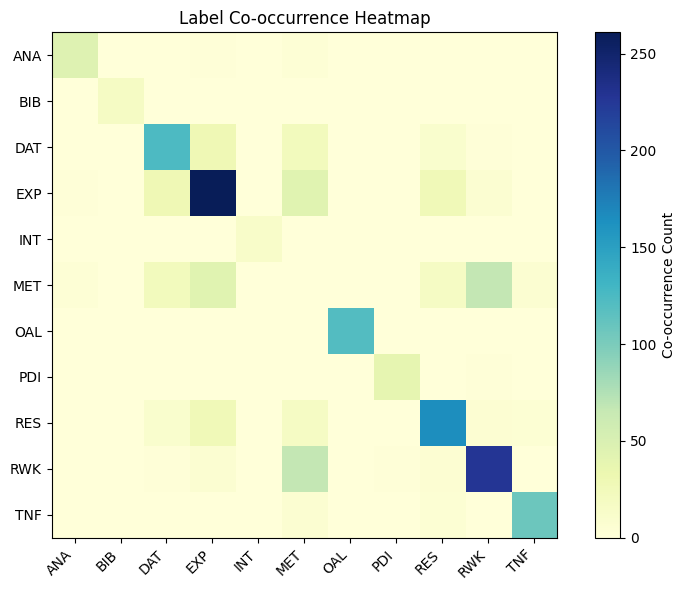

In [10]:
# Extract labels into a new DataFrame
label_columns = ['ANA', 'BIB', 'DAT', 'EXP', 'INT', 'MET', 'OAL', 'PDI', 'RES', 'RWK', 'TNF']
labels_df = pd.DataFrame(df['labels'].tolist(), columns=label_columns)

co_occurrence = labels_df.T.dot(labels_df)
co_occurrence.loc['MET','MET'] = 0
# Create the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(co_occurrence, cmap="YlGnBu", interpolation="nearest")
plt.colorbar(label="Co-occurrence Count")
# Add ticks and labels
plt.xticks(ticks=np.arange(len(label_columns)), labels=label_columns, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(label_columns)), labels=label_columns)
# Add title
plt.title("Label Co-occurrence Heatmap")
plt.tight_layout()

plt.show()

# evaluate prediction results

In [12]:
# Convert DataFrame to Dataset
df_train = df_train[['sentence', 'labels']]
dataset = Dataset.from_pandas(df_train)
num_themes = 11
# Load the pretrained MLM model
#"/home/nana/EMNLP2023_jiu_jitsu_argumentation_for_rebuttals/JitsuPEER_data_and_models_v1/models/bert-base-uncased_neg"
#"/home/nana/DASP_report_template/model_training/nlp/review_to_theme/results/final_model"
#"/home/nana/DASP_report_template/model_training/nlp/review_to_theme/results/pretrained/epoch_10/5e-05/checkpoint-1810"
model_checkpoint = "/home/nana/DASP_report_template/model_training/nlp/review_to_theme/results/pretrained/epoch_10/5e-05/checkpoint-1810"
model = BertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_themes, problem_type="multi_label_classification")
# Initialize the tokenizer
# /home/nana/DASP_report_template/model_training/nlp/review_to_theme/results/final_model
# bert-base-uncased
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize your dataset
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=128)

# Assuming dataset has columns 'text' and 'labels' (labels should be a binary vector per example)
dataset = dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 1811/1811 [00:00<00:00, 1913.92 examples/s]


In [13]:
dataset = dataset.train_test_split(test_size=0.2, seed=42)  # 80% train, 20% test
train_dataset = dataset['train']
eval_dataset = dataset['test']

# Ensure the dataset is in the correct format (PyTorch or TensorFlow format)
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
eval_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Convert logits to predictions for multi-class classification
    probs = torch.sigmoid(torch.tensor(predictions))
    # Convert probabilities to binary predictions using a threshold of 0.5
    threshold = 0.5
    binary_preds = (probs > threshold).int()
    # Calculate metrics
    accuracy = accuracy_score(labels, binary_preds)
    precision = precision_score(labels, binary_preds, average="macro")
    recall = recall_score(labels, binary_preds, average="macro")
    f1 = f1_score(labels, binary_preds, average="macro")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [15]:
from transformers import TrainingArguments
from transformers import Trainer

base_output_dir = "./results"
epoch = 10
learning_rate = 5e-5
training_args = TrainingArguments(
    output_dir=f"{base_output_dir}/pretrained_model_normal_tokenizer/epoch_{epoch}/{learning_rate}",           # Directory to save results
    evaluation_strategy="epoch",      # Evaluate after each epoch
    learning_rate=learning_rate,               # Learning rate
    per_device_train_batch_size=8,    # Batch size per device (GPU or CPU)
    per_device_eval_batch_size=8,     # Batch size for evaluation
    num_train_epochs=epoch,               # Number of epochs
    logging_dir="./logs",             # Logging directory
    save_strategy="epoch"             # Save model after each epoch
)

trainer = Trainer(
    model=model,                      # The model we defined above
    args=training_args,               # Training arguments
    train_dataset=train_dataset,      # Training dataset
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

/home/nana/anaconda3/envs/model_training/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
# Evaluate the model
eval_results = trainer.evaluate(metric_key_prefix="eval")
print(eval_results)
trainer.save_metrics("eval", eval_results)

{'eval_loss': 0.08872207254171371, 'eval_model_preparation_time': 0.0029, 'eval_accuracy': 0.7823691460055097, 'eval_precision': 0.8216933625206658, 'eval_recall': 0.8031978930868469, 'eval_f1': 0.7993171743236648, 'eval_runtime': 4.3831, 'eval_samples_per_second': 82.818, 'eval_steps_per_second': 10.495}


In [19]:
# Make predictions
predictions = trainer.predict(eval_dataset)
logits = predictions.predictions

# Apply sigmoid activation
probs = torch.sigmoid(torch.tensor(logits))

# Convert probabilities to binary predictions
threshold = 0.5
binary_preds = (probs > threshold).int()
true_labels = predictions.label_ids

In [24]:
from sklearn.metrics import classification_report
# Calculate metrics using sklearn
report = classification_report(true_labels, binary_preds.numpy(), target_names=label_columns, output_dict=True)
# Convert the classification report into a DataFrame
df_report = pd.DataFrame(report).transpose()
styled_df = df_report.style.set_table_styles([
    {'selector': 'tr:nth-of-type(even)', 'props': [('background-color', 'lightgrey'), ('color', 'black')]},
    {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', 'white'), ('color', 'black')]}
])
styled_df


/home/nana/anaconda3/envs/model_training/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
ANA,0.714286,0.714286,0.714286,7.000000
BIB,1.000000,0.400000,0.571429,5.000000
DAT,0.848485,1.000000,0.918033,28.000000
EXP,0.912281,0.881356,0.896552,59.000000
INT,0.500000,0.500000,0.500000,2.000000
MET,0.893855,0.919540,0.906516,174.000000
OAL,0.962963,0.896552,0.928571,29.000000
PDI,0.888889,1.000000,0.941176,8.000000
RES,0.743590,0.828571,0.783784,35.000000
RWK,0.756098,0.794872,0.775000,39.000000
